# House price Regression

Predict house price from various characteristic of the house.

Based on Ames, Iowa dataset

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from scipy.stats import skew
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)


Populating the interactive namespace from numpy and matplotlib


## Data preparation

Add a new feature, and split train-test. Create a validation set.

In [2]:
def clean_data(data, is_train_data=True):
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
    if is_train_data == True:
        data = data[data.GrLivArea < 4000]        
    return data

In [3]:
df = pd.read_csv('data/ames/train.csv')
df["LogSalePrice"] = np.log1p(df["SalePrice"])
numeric_feats = df.dtypes[df.dtypes != "object"].index

skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

df[skewed_feats] = np.log1p(df[skewed_feats])
df = pd.get_dummies(df)
df = df.fillna(df.mean())

In [4]:
y = df['LogSalePrice']
X = df.drop(['Id', 'SalePrice', 'LogSalePrice'], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=56)

# ML Experiment

Run with different hyperparams and pick the best.

In [6]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import r2_score
import itertools
import operator

In [7]:
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [8]:
model_lasso = LassoCV(cv=5, alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)
rmse_cv(model_lasso).mean()

0.11080537480778976

In [9]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 109 variables and eliminated the other 179 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

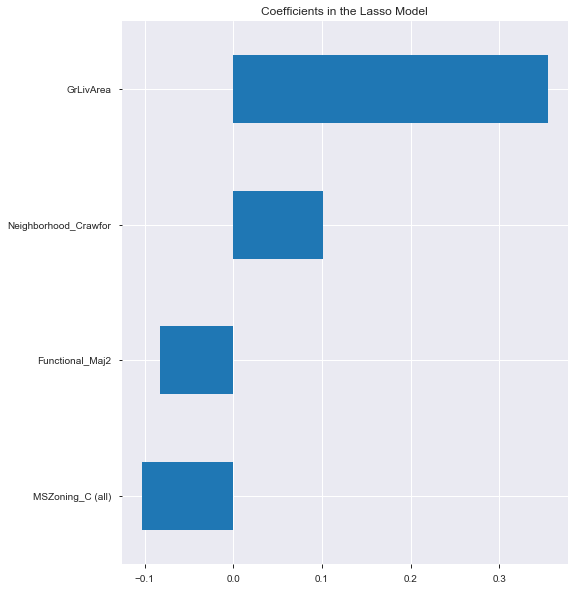

In [42]:
imp_coef = pd.concat([coef.sort_values().head(2),
                     coef.sort_values().tail(2)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [43]:
mini_X_train = X_train.loc[:, imp_coef.index]
mini_X_test = X_test.loc[:, imp_coef.index]
mini_lasso = Lasso(alpha=model_lasso.alpha_).fit(mini_X_train, y_train)
rmse_cv(mini_lasso).mean()

0.1102932218570903

In [44]:
feature_map = {
    "LotArea": "3a6fdeb6e6da11e99130000000000002", #
    "1stFlrSF": "c6c484d8e55a11e9b9ee000000000002", #
}

In [45]:
authors_ids = ['5b69b6dee6f111e9a037000000000007']
source_datasets = ['f4ded1b0dfca11e9ab5e000000000004'] #
neighborhoods = ['99397a46e6f111e9953200000000000a'] #
population = 'dd103c38ec6411e99cf6000000000008' #

# Submission

In [46]:
experiment_name = "Ames, Iowa housing price regression using top 20 most performant features."
experiment_lede = "Lasso model to model house price."
experiment_description = """
In this experiment, a Lasso model was trained all the features found in Kaggle's Ames, Iowa housing price dataset.
The top 20 most performat features was selected.
"""
study_source = "https://github.com/mjamei/sample-notebooks/blob/master/notebooks/Ames%20Housing%20Price%20Regression.ipynb"

In [47]:
import system_client as system
from onnxmltools.convert.common.data_types import Int64TensorType
num_features = mini_X_test.shape[1]
initial_type = [('feature_input', Int64TensorType([1, num_features]))]

In [48]:
with system.SupervisedMLSession(config_path='dev.json', user_auth_path='auth.json') as session1:
    evaluation = session1.add_evaluation(mini_lasso, mini_X_test, pd.DataFrame(y_test), initial_types=initial_type)
    system_model = session1.add_model(
        label='Best model',
        algorithm='Lasso',
        target_name='LogSalePrice',
        model_params=mini_lasso.get_params(),
#         source_datasets=source_datasets,
#         model_population=population,
#         neighborhoods=neighborhoods,
        evaluation=evaluation
    )
#     session1.map_features_to_variables(feature_to_variable_map=feature_map)
    session1.add_experiment_metadata(
        name=experiment_name,
        lede=experiment_lede,
        description=experiment_description,
        source=study_source
    )
#     session1.register_remote_evaluator(system_model, mini_lasso, mini_X_test, pd.DataFrame(y_test))
    session1.submit()

The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.


EVALUATOR OUTPUT 2019-10-18 14-58-18 Loading the ONNX Model...EVALUATOR OUTPUT 2019-10-18 14-58-18 SUCCESS...
EVALUATOR OUTPUT 2019-10-18 14-58-18 Creating descriptive stats for X...EVALUATOR OUTPUT 2019-10-18 14-58-19 SUCCESS...
EVALUATOR OUTPUT 2019-10-18 14-58-19 Creating descriptive stats for y...EVALUATOR OUTPUT 2019-10-18 14-58-19 SUCCESS...
EVALUATOR OUTPUT 2019-10-18 14-58-19 Calculating model MeanSquaredError...EVALUATOR OUTPUT 2019-10-18 14-58-19 SUCCESS...
EVALUATOR OUTPUT 2019-10-18 14-58-19 Calculating model R2Score...EVALUATOR OUTPUT 2019-10-18 14-58-19 SUCCESS...
EVALUATOR OUTPUT 2019-10-18 14-58-19 Calculating permutation for MeanSquaredError...EVALUATOR OUTPUT 2019-10-18 14-58-19 SUCCESS...
EVALUATOR OUTPUT 2019-10-18 14-58-19 Calculating permutation for R2Score...EVALUATOR OUTPUT 2019-10-18 14-58-19 SUCCESS...
EVALUATOR OUTPUT 2019-10-18 14-58-19 Calculating PDP...EVALUATOR OUTPUT 2019-10-18 14-58-20 SUCCESS...
EVALUATOR OUTPUT 2019-10-18 14-58-20 Calculating Feature 

In [41]:
session1.submit()

ServerError: There was an error in processing your request:: b'{"message": "Object already persisted to s3://system-dev-subgraphs-ps83yho35j8o7tfx88nu1v4q/969de433-7f52-4812-86b1-a11f3bdc184f/in_progress/bd2d0d8731047888060eb989e1c898f15eec3ab60f85933bc8499c391f3ef035/subgraph.pb!"}\n'

# Multiple hyperparams

In [19]:
experiment2_name = "Ames, Iowa housing price classifier with various hyperparameters."
experiment2_lede = "XBoost model to predict whether a house price is above median."
experiment2_description = """
In this experiment, an XGBoost model was trained all the features found in Kaggle's Ames, Iowa housing price dataset.
The top 20 most performat features was selected with Gain as the feature contribution method.
Same model was trained and tested with different hyper parameters.
"""

In [21]:
with system.SupervisedMLSession(config_path='local.json', authors=authors_ids) as session:
 
    for max_depth, n_estimator, gamma in [
        (3, 15, 0),
        (3, 20, 0),
        (4, 15, 0),
        (2, 15, 0),
        (3, 15, 0.01)
    ]:
        model = xgb.XGBClassifier(
            max_depth=max_depth,
            n_estimator=n_estimator,
            gamma=gamma)
        model.fit(mini_X_train.values, y_train)
        evaluation = session.add_evaluation(
            model,
            mini_X_test,
            pd.DataFrame(y_test),
            initial_types=initial_type)
        system_model = session.add_model(
            target_name='SalePrice',
            algorithm='XGBoost',
            label=f'max_depth={max_depth}, n_estimator={n_estimator}, gamma={gamma}',
            model_params=model.get_params(),
            source_datasets=source_datasets,
            model_population=population,
            evaluation=evaluation,
            neighborhoods=neighborhoods)
    session.map_features_to_variables(feature_to_variable_map=feature_map)
    session.add_experiment_metadata(
        name=experiment2_name,
        lede=experiment2_lede,
        description=experiment2_description
    )
    session.submit()

Setting Mehdi Jamei as an author.


The maximum opset needed by this model is only 1.


EVALUATOR OUTPUT 2019-10-14 16-46-38 Loading the ONNX Model...EVALUATOR OUTPUT 2019-10-14 16-46-39 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-46-39 Creating descriptive stats for X...EVALUATOR OUTPUT 2019-10-14 16-46-39 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-46-39 Creating descriptive stats for y...EVALUATOR OUTPUT 2019-10-14 16-46-39 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-46-40 Calculating model F1Score...EVALUATOR OUTPUT 2019-10-14 16-46-40 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-46-40 Calculating model AccuracyScore...EVALUATOR OUTPUT 2019-10-14 16-46-40 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-46-40 Calculating model RocAucScore...EVALUATOR OUTPUT 2019-10-14 16-46-40 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-46-40 Calculating model RocCurve...EVALUATOR OUTPUT 2019-10-14 16-46-40 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-46-40 Calculating model ConfusionMatrix...EVALUATOR OUTPUT 2019-10-14 16-46-40 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-46-40 Calculating permutation for F

The maximum opset needed by this model is only 1.


EVALUATOR OUTPUT 2019-10-14 16-47-09 Loading the ONNX Model...EVALUATOR OUTPUT 2019-10-14 16-47-09 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-47-09 Creating descriptive stats for X...EVALUATOR OUTPUT 2019-10-14 16-47-10 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-47-10 Creating descriptive stats for y...EVALUATOR OUTPUT 2019-10-14 16-47-10 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-47-10 Calculating model F1Score...EVALUATOR OUTPUT 2019-10-14 16-47-10 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-47-10 Calculating model AccuracyScore...EVALUATOR OUTPUT 2019-10-14 16-47-10 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-47-10 Calculating model RocAucScore...EVALUATOR OUTPUT 2019-10-14 16-47-10 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-47-10 Calculating model RocCurve...EVALUATOR OUTPUT 2019-10-14 16-47-10 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-47-10 Calculating model ConfusionMatrix...EVALUATOR OUTPUT 2019-10-14 16-47-10 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-47-10 Calculating permutation for F

The maximum opset needed by this model is only 1.


EVALUATOR OUTPUT 2019-10-14 16-47-44 Loading the ONNX Model...EVALUATOR OUTPUT 2019-10-14 16-47-45 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-47-45 Creating descriptive stats for X...EVALUATOR OUTPUT 2019-10-14 16-47-46 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-47-46 Creating descriptive stats for y...EVALUATOR OUTPUT 2019-10-14 16-47-46 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-47-46 Calculating model F1Score...EVALUATOR OUTPUT 2019-10-14 16-47-46 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-47-46 Calculating model AccuracyScore...EVALUATOR OUTPUT 2019-10-14 16-47-46 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-47-46 Calculating model RocAucScore...EVALUATOR OUTPUT 2019-10-14 16-47-46 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-47-46 Calculating model RocCurve...EVALUATOR OUTPUT 2019-10-14 16-47-46 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-47-46 Calculating model ConfusionMatrix...EVALUATOR OUTPUT 2019-10-14 16-47-46 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-47-46 Calculating permutation for F

The maximum opset needed by this model is only 1.


EVALUATOR OUTPUT 2019-10-14 16-48-24 Loading the ONNX Model...EVALUATOR OUTPUT 2019-10-14 16-48-24 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-48-24 Creating descriptive stats for X...EVALUATOR OUTPUT 2019-10-14 16-48-25 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-48-25 Creating descriptive stats for y...EVALUATOR OUTPUT 2019-10-14 16-48-25 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-48-25 Calculating model F1Score...EVALUATOR OUTPUT 2019-10-14 16-48-25 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-48-25 Calculating model AccuracyScore...EVALUATOR OUTPUT 2019-10-14 16-48-25 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-48-25 Calculating model RocAucScore...EVALUATOR OUTPUT 2019-10-14 16-48-25 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-48-25 Calculating model RocCurve...EVALUATOR OUTPUT 2019-10-14 16-48-25 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-48-25 Calculating model ConfusionMatrix...EVALUATOR OUTPUT 2019-10-14 16-48-26 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-48-26 Calculating permutation for F

The maximum opset needed by this model is only 1.


EVALUATOR OUTPUT 2019-10-14 16-49-07 Loading the ONNX Model...EVALUATOR OUTPUT 2019-10-14 16-49-07 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-49-07 Creating descriptive stats for X...EVALUATOR OUTPUT 2019-10-14 16-49-09 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-49-09 Creating descriptive stats for y...EVALUATOR OUTPUT 2019-10-14 16-49-09 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-49-09 Calculating model F1Score...EVALUATOR OUTPUT 2019-10-14 16-49-09 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-49-09 Calculating model AccuracyScore...EVALUATOR OUTPUT 2019-10-14 16-49-10 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-49-10 Calculating model RocAucScore...EVALUATOR OUTPUT 2019-10-14 16-49-10 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-49-10 Calculating model RocCurve...EVALUATOR OUTPUT 2019-10-14 16-49-10 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-49-10 Calculating model ConfusionMatrix...EVALUATOR OUTPUT 2019-10-14 16-49-10 SUCCESS...
EVALUATOR OUTPUT 2019-10-14 16-49-10 Calculating permutation for F

# Different Algorithms

In [22]:
experiment3_name = "Ames, Iowa housing price classifier with various classification algorithms."
experiment3_lede = "XBoost model to predict whether a house price is above median."
experiment3_description = """
In this experiment, an XGBoost model was trained all the features found in Kaggle's Ames, Iowa housing price dataset.
The top 20 most performat features was selected with Gain as the feature contribution method.
Random Forest, Logistic Regression and XGBoost models were trained and tested.
"""

In [23]:
import sklearn

In [24]:
rf_model = sklearn.ensemble.RandomForestClassifier()
logit_model = sklearn.linear_model.LogisticRegression()
xgb_model = xgb.XGBClassifier(
            max_depth=best_max_depth,
            n_estimator=best_n_estimator,
            gamma=best_gamma)

In [18]:
with system.SupervisedMLSession(config_path='local.json', authors=authors_ids) as session3:
 
    for model in [xgb_model, rf_model, logit_model]:
        model.fit(mini_X_train.values, y_train.astype(int))
        evaluation = session3.add_evaluation(
            model,
            mini_X_test,
            pd.DataFrame(y_test.astype(int)),
            initial_types=initial_type)
        system_model = session3.add_model(
            target_name='SalePrice',
            algorithm=model.__class__.__name__,
            label=f'algorithm={model.__class__.__name__}',
            model_params=model.get_params(),
            source_datasets=source_datasets,
            model_population=population,
            evaluation=evaluation,
            neighborhoods=neighborhoods)
    session3.map_features_to_variables(feature_to_variable_map=feature_map)
    session3.add_experiment_metadata(
        name=experiment3_name,
        lede=experiment3_lede,
        description=experiment3_description
    )
    session3.submit()

Setting Mehdi Jamei as an author.


The maximum opset needed by this model is only 1.


EVALUATOR OUTPUT 2019-10-09 10-55-25 Loading the ONNX Model...EVALUATOR OUTPUT 2019-10-09 10-55-25 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-55-25 Creating descriptive stats for X...EVALUATOR OUTPUT 2019-10-09 10-55-27 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-55-27 Creating descriptive stats for y...EVALUATOR OUTPUT 2019-10-09 10-55-27 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-55-27 Calculating model F1Score...EVALUATOR OUTPUT 2019-10-09 10-55-27 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-55-27 Calculating model AccuracyScore...EVALUATOR OUTPUT 2019-10-09 10-55-27 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-55-27 Calculating model RocAucScore...EVALUATOR OUTPUT 2019-10-09 10-55-28 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-55-28 Calculating model RocCurve...EVALUATOR OUTPUT 2019-10-09 10-55-28 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-55-28 Calculating model ConfusionMatrix...EVALUATOR OUTPUT 2019-10-09 10-55-28 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-55-28 Calculating permutation for F

The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.


EVALUATOR OUTPUT 2019-10-09 10-56-49 Loading the ONNX Model...EVALUATOR OUTPUT 2019-10-09 10-56-50 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-56-50 Creating descriptive stats for X...EVALUATOR OUTPUT 2019-10-09 10-56-51 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-56-51 Creating descriptive stats for y...EVALUATOR OUTPUT 2019-10-09 10-56-52 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-56-52 Calculating model F1Score...EVALUATOR OUTPUT 2019-10-09 10-56-52 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-56-52 Calculating model AccuracyScore...EVALUATOR OUTPUT 2019-10-09 10-56-52 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-56-52 Calculating model RocAucScore...EVALUATOR OUTPUT 2019-10-09 10-56-52 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-56-52 Calculating model RocCurve...EVALUATOR OUTPUT 2019-10-09 10-56-52 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-56-52 Calculating model ConfusionMatrix...EVALUATOR OUTPUT 2019-10-09 10-56-54 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-56-54 Calculating permutation for F

The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.


EVALUATOR OUTPUT 2019-10-09 10-57-30 Loading the ONNX Model...EVALUATOR OUTPUT 2019-10-09 10-57-30 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-57-30 Creating descriptive stats for X...EVALUATOR OUTPUT 2019-10-09 10-57-32 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-57-32 Creating descriptive stats for y...EVALUATOR OUTPUT 2019-10-09 10-57-32 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-57-32 Calculating model F1Score...EVALUATOR OUTPUT 2019-10-09 10-57-32 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-57-32 Calculating model AccuracyScore...EVALUATOR OUTPUT 2019-10-09 10-57-32 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-57-32 Calculating model RocAucScore...EVALUATOR OUTPUT 2019-10-09 10-57-32 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-57-32 Calculating model RocCurve...EVALUATOR OUTPUT 2019-10-09 10-57-32 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-57-32 Calculating model ConfusionMatrix...EVALUATOR OUTPUT 2019-10-09 10-57-32 SUCCESS...
EVALUATOR OUTPUT 2019-10-09 10-57-32 Calculating permutation for F